In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
from tqdm import tqdm
from IPython.display import display, HTML
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2    

In [2]:
from GenModels.GM.States.GraphicalMessagePassing import DataGraph, \
                                                        GraphCategoricalForwardBackwardFBS
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior

# Create the graph

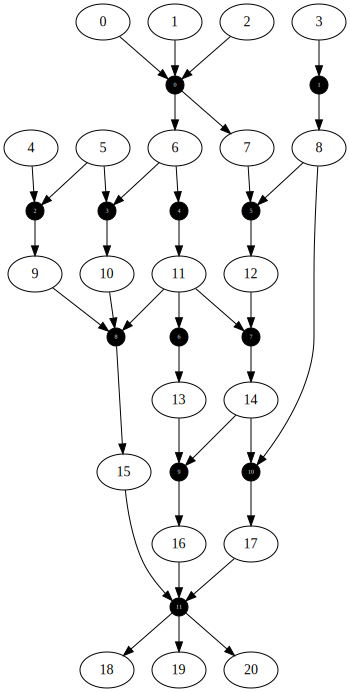

In [3]:
# Latent state size of 3 so that we can use rgb values to interpret them
d_latent = 3
d_obs    = 2

# This is the number of times we measure an emission from the same 
# latent state for a node
measurements = 3

graph = DataGraph()
graph.addEdge( parents=[ 0, 1, 2 ], children=[ 6, 7 ] )
graph.addEdge( parents=[ 3 ], children=[ 8 ] )
graph.addEdge( parents=[ 4, 5 ], children=[ 9 ] )
graph.addEdge( parents=[ 5, 6 ], children=[ 10 ] )
graph.addEdge( parents=[ 6 ], children=[ 11 ] )
graph.addEdge( parents=[ 7, 8 ], children=[ 12 ] )
graph.addEdge( parents=[ 11 ], children=[ 13 ] )
graph.addEdge( parents=[ 11, 12 ], children=[ 14 ] )
graph.addEdge( parents=[ 9, 10, 11 ], children=[ 15 ] )
graph.addEdge( parents=[ 13, 14 ], children=[ 16 ] )
graph.addEdge( parents=[ 8, 14 ], children=[ 17 ] )
graph.addEdge( parents=[ 15, 16, 17 ], children=[ 18, 19, 20 ] )

feedback_set = np.array( [ 5, 6, 11, 14 ] )
graph.draw( horizontal=False )

# Helper class to actually do the state and emission sampling

In [4]:
class GraphState():
    
    def __init__( self, msg ):
        self.msg = msg
        self.node_states = {}
        self.node_emissions = {}        
        
    def __call__( self, node_list ):
        # Compute P( x_c | x_p1..pN ) and P( y_c | x_c )
        
        for node in node_list:
            parents, parent_order = self.msg.getParents( node, get_order=True )
            ndim = len( parents ) + 1
            if( len( parents ) == 0 ):
                prob = self.msg.pi0
            else:
                indices = [ [ self.node_states[ o ] ] for o in parent_order ]
                prob = self.msg.pis[ ndim ][ indices ].ravel()
                
            state = Categorical.sample( nat_params=( prob, ) )[ 0 ]
            self.node_states[ node ] = state
            self.node_emissions[ node ] = Categorical.sample( nat_params=( self.msg.emission_dist[ state ], ) )[ 0 ]

# Generate the true dynamics

In [ ]:
# Initial dist
initial_dist = Categorical( hypers=dict( alpha=np.ones( d_latent ) * 100 ) )
initial_sample = initial_dist.pi

# Check how many transition distributions we need
all_transition_counts = set()
for parents in graph.edge_parents:
    ndim = len( parents ) + 1
    all_transition_counts.add( ndim )

# Create the transition distribution
transition_dists = {}
transition_samples = []
for ndim in all_transition_counts:
    alpha = np.arange( np.prod( [ d_latent for _ in range( ndim ) ] ) ).reshape( [ d_latent for _ in range( ndim ) ] )
    dist = TensorTransition( hypers=dict( alpha=alpha + 100 ) )
    transition_dists[ ndim ] = dist
    transition_samples.append( dist.pi )

# Emission dist
emission_dist = TensorTransition( hypers=dict( alpha=np.arange( d_latent*d_obs ).reshape( ( d_latent, d_obs ) ) + 100 ) )
emission_sample = emission_dist.pi

# Create the message passer and initialize
true_msg = GraphCategoricalForwardBackwardFBS()
true_msg.updateParams( initial_sample, transition_samples, emission_sample, data_graphs=[ ( graph, feedback_set ) ] )

# Sample data and also randomly set the true latent state to be used

In [5]:
# Generate data
graph_state = GraphState( true_msg )
true_msg.forwardPass( graph_state )

# Add the data and also randomly set the true latent state
for node in graph.nodes:
    data = np.repeat( graph_state.node_emissions[ node ], measurements )
    graph.updateNodeData( node, data )
    if( np.random.random() > 0.6 ):
        graph.addPossibleLatentStates( node, [ graph_state.node_states[ node ] ] )

In [6]:
print( graph_state.node_emissions )

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1}


In [16]:
print( graph.possible_latent_states )

{5: [1], 6: [2], 12: [0], 14: [2], 15: [0], 16: [0]}


# Create the model

In [7]:
# Initial dist
initial_dist = Categorical( hypers=dict( alpha=np.ones( d_latent ) ) )
initial_sample = initial_dist.pi

# Check how many transition distributions we need
all_transition_counts = set()
for parents in graph.edge_parents:
    ndim = len( parents ) + 1
    all_transition_counts.add( ndim )

# Create the transition distribution
transition_dists = {}
transition_samples = []
for ndim in all_transition_counts:
    dist = TensorTransition( hypers=dict( alpha=np.ones( [ d_latent for _ in range( ndim ) ] ) ) )
    transition_dists[ ndim ] = dist
    transition_samples.append( dist.pi )

# Emission dist
emission_dist = TensorTransition( hypers=dict( alpha=np.ones( ( d_latent, d_obs ) ) ) )
emission_sample = emission_dist.pi

# Create the message passer and initialize
msg = GraphCategoricalForwardBackwardFBS()
msg.updateParams( initial_sample, transition_samples, emission_sample, data_graphs=[ ( graph, feedback_set ) ] )

# Helper class to sample smoothed states

In [8]:
class GraphSmoothedState():
    
    def __init__( self, msg, U, V ):
        self.msg = msg
        self.node_states = {}
        self.U = U
        self.V = V
        
    def __call__( self, node_list ):
        # Compute P( x_c | x_p1..pN, Y )
        vals = self.msg.conditionalParentChild( self.U, self.V, node_list )
        
        for node, probs in vals:
            parents, parent_order = msg.getParents( node, get_order=True )
            if( len( parents ) == 0 ):
                prob = probs
            else:
                indices = [ [ self.node_states[ o ] ] for o in parent_order ]
                prob = probs[ indices ].ravel()
            
            # Sample from P( x_c | x_p1..pN, Y )
            state = Categorical.sample( nat_params=( prob, ) )[ 0 ]
            self.node_states[ node ] = state

# X ~ P( X | π<sub>0</sub>, π, L, Y )

In [9]:
# Sample X ~ P( X | Y )
def stateResample( msg, initial_dist, transition_dists, emission_dist ):
    msg.updateParams( initial_dist.pi, [ trans.pi for trans in transition_dists.values() ], emission_dist.pi )
    U, V = msg.filter()
    graph_state = GraphSmoothedState( msg, U, V )
    msg.forwardPass( graph_state )
    return graph_state, U, V

# π<sub>0</sub> ~ P( π<sub>0</sub> | π, L, X, Y )

In [10]:
# Sample pi0 ~ P( pi0 | alpha_0, X )
def initialDistResample( msg, graph_state, initial_dist ):
    root_states = np.array( [ state for node, state in graph_state.node_states.items() if msg.nParents( node ) == 0 ] )
    initial_dist.resample( x=root_states )

# π ~ P( π | π<sub>0</sub>, L, X, Y )

In [11]:
class TransitionBins():
    def __init__( self, msg, graph_state, ndims ):
        self.msg = msg
        self.graph_state = graph_state
        self.counts = dict( [ ( ndim, [ [] for _ in range( ndim ) ] ) for ndim in ndims ] )
    
    def __call__( self, node_list ):
        for node in filter( lambda n: self.msg.nParents( n ) > 0, node_list ):
            parents, order = self.msg.getParents( node, get_order=True )
            ndim = parents.shape[ 0 ] + 1
            for i, p in zip( order, parents ):
                self.counts[ ndim ][ i ].append( self.graph_state.node_states[ p ] )
            self.counts[ ndim ][ -1 ].append( self.graph_state.node_states[ node ] )
            
# Sample pi ~ P( pi | alpha_pi, X )
def transitionResample( msg, graph_state, transition_dists ):
    transition_bins = TransitionBins( msg, graph_state, transition_dists.keys() )
    msg.forwardPass( transition_bins )
    for ndim in list( transition_dists.keys() ):
        x = [ np.array( count ) for count in transition_bins.counts[ ndim ] ]
        transition_dists[ ndim ].resample( x )

# L ~ P( L | π<sub>0</sub>, π, X, Y )

In [12]:
# Sample L ~ P( L | alpha_L, X, Y )
def emissionResample( msg, graph_state, emission_dist ):
    states = []
    emissions = []
    for node in msg.nodes:
        state = graph_state.node_states[ node ]
        state_addition = state * np.ones_like( msg.ys[ node ] )
        states.extend( state_addition.tolist() )
        emissions.extend( msg.ys[ node ].tolist() )
    x = [ np.array( states ), np.array( emissions ) ]
    emission_dist.resample( x )

In [13]:
import matplotlib

# Path to tmp folder where the intermediate images will be rendered
tmp_folder = top_level_dir + '/GenModels/tmp'

def genStyle( probs ):
    color = matplotlib.colors.to_hex( probs )
    return dict( fontcolor='black', style='filled', color=color )

# Run the gibbs sampler for 100 iterations

In [14]:
# Because there are known latent states, there are -inf values that get passed everywhere and cause warnings
with np.errstate( all='ignore' ):

    tit = tqdm( range( 100 ) )
    for i in tit:
        graph_state, U, V = stateResample( msg, initial_dist, transition_dists, emission_dist )
        marginal = msg.marginalProb( U, V, 0 )
        tit.set_description( '%5.3f'%( marginal ) )

        initialDistResample( msg, graph_state, initial_dist )
        transitionResample( msg, graph_state, transition_dists )
        emissionResample( msg, graph_state, emission_dist )

        node_smoothed = msg.nodeSmoothed( U, V, msg.nodes )
        styles = dict( [ ( node, genStyle( np.exp( probs ) ) ) for node, probs in node_smoothed ] )
        node_to_style_key = dict( [ ( node, node ) for node in msg.nodes ] )

        output_name = 'graph_%d'%( i )

        # Draw the graph
        msg.toGraph().draw( styles=styles, 
                            horizontal=False, 
                            node_to_style_key=node_to_style_key, 
                            output_folder=tmp_folder, 
                            output_name=output_name )


-17.738: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


In [17]:
# Convert the images to a gif using ImageMagick
image_paths = [ tmp_folder + '/graph_%d.png'%( j ) for j in range( i + 1 ) ]
commands = [ 'convert', '-loop', '0', '-delay', '20' ] + image_paths + [ 'hmm_gibbs.gif' ]
subprocess.call( commands )

# Delete the contents of tmp
subprocess.call( [ 'rm' ] + image_paths )

# Display the gif
HTML( '<img src="./%s">'%( 'hmm_gibbs.gif' ) )